In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [11]:
df = pd.read_csv("../data/merged/merged_data.csv")

In [12]:
df

,Year,Week,Resort,Visitors,State,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
0,2014,1,Mt. Baw Baw,555.0,VIC,5.022449,-0.338776,236.2
1,2014,2,Mt. Baw Baw,804.0,VIC,4.683673,-0.440816,125.4
2,2014,3,Mt. Baw Baw,993.0,VIC,0.308163,-2.553061,634.2
3,2014,4,Mt. Baw Baw,2976.0,VIC,1.236735,-2.363265,301.2
4,2014,5,Mt. Baw Baw,11112.0,VIC,-0.200000,-3.516327,257.0
...,...,...,...,...,...,...,...,...
1645,2024,11,Charlotte Pass,43372.0,NSW,5.331250,0.687234,237.8
1646,2024,12,Charlotte Pass,38295.0,NSW,4.300000,0.248980,434.6
1647,2024,13,Charlotte Pass,21014.0,NSW,6.597917,-0.083673,254.2
1648,2024,14,Charlotte Pass,7257.0,NSW,6.491837,-0.304167,165.0


In [13]:
# df = df[df["Resort"] != "Mt. Stirling"]

In [14]:
# df_bawbaw = df[df["Resort"] == "Mt. Baw Baw"]


In [15]:
df = df.rename(columns={
    "Maximum temperature (Degree C)": "avg_max_temp",
    "Minimum temperature (Degree C)": "avg_min_temp",
    "Rainfall amount (millimetres)": "sum_precip"
})

In [16]:
# --- 1. Split into Train/Validation/Test ---
train = df[~df["Year"].isin([2020, 2021, 2024])]   # 2014–2023
valid = df[df["Year"] == 2024]  # validation set
# test  = df[df["Year"] == 2025]  # prediction target (no labels)

X_train = train[["Resort","Week","avg_max_temp","avg_min_temp","sum_precip"]]
y_train = train["Visitors"]

X_valid = valid[["Resort","Week","avg_max_temp","avg_min_temp","sum_precip"]]
y_valid = valid["Visitors"]

# X_test  = test[["Resort","Week","avg_max_temp","avg_min_temp","sum_precip"]]  # no y_test

# Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# --- 2. Preprocessing ---
categorical = ["Resort"]
numeric = ["Week", "avg_max_temp","avg_min_temp","sum_precip"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric)
    ]
)

In [18]:
xgb_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=3000,
        learning_rate=0.005,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

In [19]:
# --- 6. Train on 2014–2023 ---
xgb_model.fit(X_train, y_train)

# --- 7. Validate on 2024 ---
y_pred_valid = xgb_model.predict(X_valid)
y_pred_valid = np.maximum(0, y_pred_valid)

# (Optional) Print a few comparisons
for i in range(30):
    print(f"Week {X_valid.iloc[i]['Week']}, Resort={X_valid.iloc[i]['Resort']}: "
          f"Actual={y_valid.iloc[i]}, Pred={y_pred_valid[i]:.0f}")

Week 1, Resort=Mt. Baw Baw: Actual=1558.0, Pred=5059
Week 2, Resort=Mt. Baw Baw: Actual=1546.0, Pred=4438
Week 3, Resort=Mt. Baw Baw: Actual=1695.0, Pred=4269
Week 4, Resort=Mt. Baw Baw: Actual=4457.0, Pred=5209
Week 5, Resort=Mt. Baw Baw: Actual=11079.0, Pred=10425
Week 6, Resort=Mt. Baw Baw: Actual=9830.0, Pred=9300
Week 7, Resort=Mt. Baw Baw: Actual=9456.0, Pred=8374
Week 8, Resort=Mt. Baw Baw: Actual=8513.0, Pred=9850
Week 9, Resort=Mt. Baw Baw: Actual=9635.0, Pred=9120
Week 10, Resort=Mt. Baw Baw: Actual=8121.0, Pred=5629
Week 11, Resort=Mt. Baw Baw: Actual=5977.0, Pred=7062
Week 12, Resort=Mt. Baw Baw: Actual=3597.0, Pred=7034
Week 13, Resort=Mt. Baw Baw: Actual=1500.0, Pred=3502
Week 14, Resort=Mt. Baw Baw: Actual=0.0, Pred=3354
Week 15, Resort=Mt. Baw Baw: Actual=0.0, Pred=2560
Week 1, Resort=Mt. Stirling: Actual=0.0, Pred=359
Week 2, Resort=Mt. Stirling: Actual=12.0, Pred=0
Week 3, Resort=Mt. Stirling: Actual=106.0, Pred=140
Week 4, Resort=Mt. Stirling: Actual=122.0, Pred=0
We

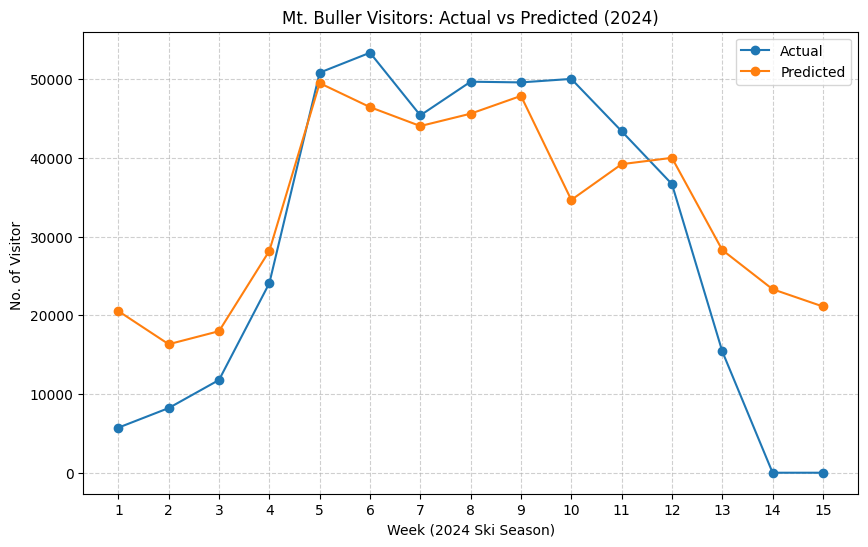

In [20]:
# Performance
import matplotlib.pyplot as plt

# attach predictions to validation set
valid = valid.copy()
valid["Pred"] = y_pred_valid   # y_pred_valid from your model.predict()

# filter any Mt. 2024 only
filtered_val_2024 = valid[(valid["Resort"]=="Mt. Buller") & (valid["Year"]==2024)]

# plot actual vs predicted for weeks 1–15
plt.figure(figsize=(10,6))
plt.plot(filtered_val_2024["Week"], filtered_val_2024["Visitors"], marker="o", label="Actual")
plt.plot(filtered_val_2024["Week"], filtered_val_2024["Pred"], marker="o", label="Predicted")
plt.xticks(range(1,16))
plt.xlabel("Week (2024 Ski Season)")
plt.ylabel("No. of Visitor ")
plt.title("Mt. Buller Visitors: Actual vs Predicted (2024)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


## Predict 2026

In [22]:
df_2026 = pd.read_csv("weekly_climate_2026.csv")

In [23]:
# --- 1. Split into Train/Validation/Test ---
train = df[~df["Year"].isin([2020, 2021])]   # 2014–2023
test  = df_2026  # prediction target (no labels) # Edit this

X_train_new = train[["Resort","Week","avg_max_temp","avg_min_temp","sum_precip"]]
y_train_new = train["Visitors"]

X_test  = test[["Resort","Week","avg_max_temp","avg_min_temp","sum_precip"]]  # no y_test

In [24]:
# --- 6. Train on 2014–2023 ---
xgb_model.fit(X_train_new, y_train_new)

# --- 7. Validate on 2025 ---
y_pred_2026 = xgb_model.predict(X_test)
y_pred_2026 = np.maximum(0, y_pred_2026)

# (Optional) Print a few comparisons
for i in range(30):
    print(f"Week {X_test.iloc[i]['Week']}, Resort={X_valid.iloc[i]['Resort']}: "
          f"Pred={y_pred_2026[i]:.0f}")

Week 1, Resort=Mt. Baw Baw: Pred=15470
Week 2, Resort=Mt. Baw Baw: Pred=9238
Week 3, Resort=Mt. Baw Baw: Pred=11490
Week 4, Resort=Mt. Baw Baw: Pred=16680
Week 5, Resort=Mt. Baw Baw: Pred=29005
Week 6, Resort=Mt. Baw Baw: Pred=29461
Week 7, Resort=Mt. Baw Baw: Pred=25506
Week 8, Resort=Mt. Baw Baw: Pred=26502
Week 9, Resort=Mt. Baw Baw: Pred=28816
Week 10, Resort=Mt. Baw Baw: Pred=28102
Week 11, Resort=Mt. Baw Baw: Pred=31780
Week 12, Resort=Mt. Baw Baw: Pred=27624
Week 13, Resort=Mt. Baw Baw: Pred=25971
Week 14, Resort=Mt. Baw Baw: Pred=20361
Week 15, Resort=Mt. Baw Baw: Pred=15056
Week 1, Resort=Mt. Stirling: Pred=13500
Week 2, Resort=Mt. Stirling: Pred=8564
Week 3, Resort=Mt. Stirling: Pred=10097
Week 4, Resort=Mt. Stirling: Pred=19036
Week 5, Resort=Mt. Stirling: Pred=36192
Week 6, Resort=Mt. Stirling: Pred=34790
Week 7, Resort=Mt. Stirling: Pred=36481
Week 8, Resort=Mt. Stirling: Pred=36124
Week 9, Resort=Mt. Stirling: Pred=37019
Week 10, Resort=Mt. Stirling: Pred=39631
Week 11, R

In [25]:
df[(df["Resort"]==resort_viz)]

,Year,Week,Resort,Visitors,State,avg_max_temp,avg_min_temp,sum_precip
660,2014,1,Mt. Buller,8296.0,VIC,5.022449,-0.338776,236.2
661,2014,2,Mt. Buller,1987.0,VIC,4.683673,-0.440816,125.4
662,2014,3,Mt. Buller,2413.0,VIC,0.308163,-2.553061,634.2
663,2014,4,Mt. Buller,18831.0,VIC,1.236735,-2.363265,301.2
664,2014,5,Mt. Buller,49217.0,VIC,-0.200000,-3.516327,257.0
...,...,...,...,...,...,...,...,...
820,2024,11,Mt. Buller,43387.0,VIC,5.331250,0.687234,237.8
821,2024,12,Mt. Buller,36668.0,VIC,4.300000,0.248980,434.6
822,2024,13,Mt. Buller,15415.0,VIC,6.597917,-0.083673,254.2
823,2024,14,Mt. Buller,0.0,VIC,6.491837,-0.304167,165.0


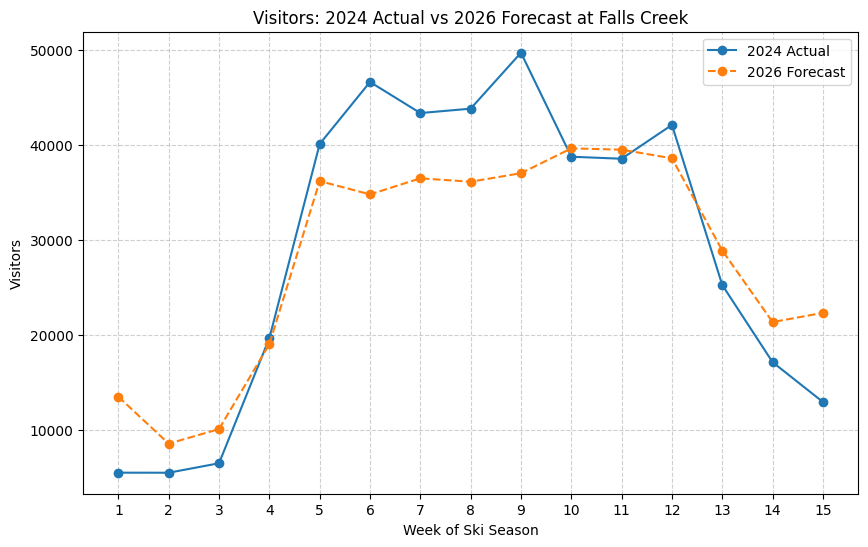

In [28]:
import matplotlib.pyplot as plt

resort_viz = "Falls Creek"
year_viz = 2024

# --- Actuals 2024 from df ---
viz_2024 = df[(df["Resort"]==resort_viz) & (df["Year"]==2024)]

# --- Predictions 2026 from test set ---
test = test.copy()
test["Pred_2026"] = y_pred_2026
viz_2026 = test[(test["Resort"]==resort_viz) & (test["Year"]==2026)]

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(viz_2024["Week"], viz_2024["Visitors"], marker="o", label="2024 Actual")
plt.plot(viz_2026["Week"], viz_2026["Pred_2026"], marker="o", linestyle="--", label="2026 Forecast")

plt.xticks(range(1,16))
plt.xlabel("Week of Ski Season")
plt.ylabel("Visitors")
plt.title("Visitors: 2024 Actual vs 2026 Forecast at Falls Creek")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [29]:
# Attach predictions
df_2026 = df_2026.copy()
df_2026["visitors_pred"] = np.maximum(0, y_pred_2026)  # ensure no negatives

# Save to CSV
df_2026.to_csv("2026_visitors_pred.csv", index=False)
print("Saved 2026_visitors_pred.csv")

# Quick check
print(df_2026.head())

Saved 2026_visitors_pred.csv
   Year  Week          Resort  avg_max_temp  avg_min_temp  sum_precip  \
0  2026     1  Charlotte Pass      2.541166     -2.107618  257.201319   
1  2026     2  Charlotte Pass      1.461646     -3.446833  212.322190   
2  2026     3  Charlotte Pass      1.381011     -3.530763  162.092907   
3  2026     4  Charlotte Pass      1.659378     -2.893326  164.693601   
4  2026     5  Charlotte Pass      1.535996     -3.145986  158.966322   

   visitors_pred  
0   15469.819336  
1    9238.454102  
2   11489.571289  
3   16679.773438  
4   29004.968750  


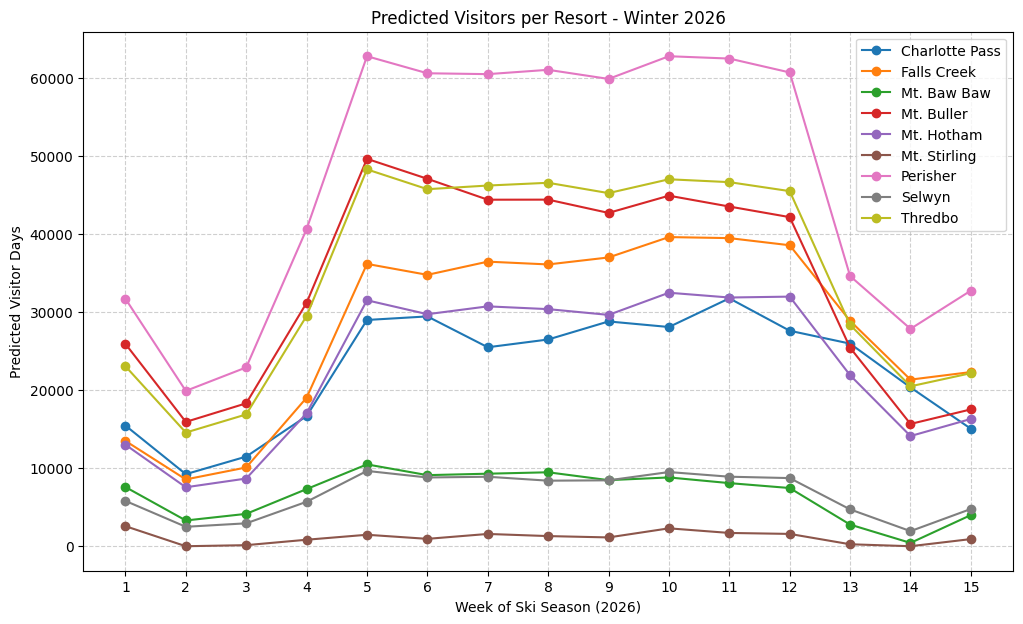

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))

# Loop through each resort and plot weekly curve
for resort in df_2026["Resort"].unique():
    subset = df_2026[df_2026["Resort"]==resort]
    plt.plot(subset["Week"], subset["visitors_pred"], marker="o", label=resort)

plt.xticks(range(1,16))
plt.xlabel("Week of Ski Season (2026)")
plt.ylabel("Predicted Visitor Days")
plt.title("Predicted Visitors per Resort - Winter 2026")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
